# Предсказание цены на фьючерс индекса RTS

Цель проекта: построить модель-помощника для предсказания цены фьючерса на индекс RTS

**План работы**  
1. Изучим и подготовим данные;
2. Определим тренд, сезонную составляющую, остатки;
3. Исследуем модель линейной регрессии;
4. Проверим модель на адекватность.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose

# 1 Подготовка

In [2]:
df = pd.read_csv('RTS_day.csv', sep=' ')

In [3]:
df.columns = df.columns.str.lower()
df.head(2)

,<ticker>,<per>,<date>,<time>,<open>,<high>,<low>,<close>,<vol>
0,SPFB.RTS,D,05/04/23,00:00:00,98100.0,98280.0,96910.0,98100.0,92118
1,SPFB.RTS,D,06/04/23,00:00:00,97940.0,98420.0,96100.0,96110.0,114772


Переименуем столбцы

In [4]:
df.columns = df.columns.str.replace('>', '')
df.columns = df.columns.str.replace('<', '')

In [5]:
df = df.drop(['per', 'ticker'], axis=1)
df.head(2)

,date,time,open,high,low,close,vol
0,05/04/23,00:00:00,98100.0,98280.0,96910.0,98100.0,92118
1,06/04/23,00:00:00,97940.0,98420.0,96100.0,96110.0,114772


In [6]:
df.tail(2)

,date,time,open,high,low,close,vol
127,04/10/23,00:00:00,101080.0,101440.0,99900.0,100010.0,65281
128,05/10/23,00:00:00,100140.0,100450.0,98350.0,99320.0,69248


Создадим колонку и приведем к формату datetime

In [7]:
df['datetime'] = df.date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%y')
df.set_index('datetime', inplace=True)
df = df.drop(['date', 'time'], axis=1)
df.head(2)

,open,high,low,close,vol
datetime,,,,,
2023-04-05,98100.0,98280.0,96910.0,98100.0,92118
2023-04-06,97940.0,98420.0,96100.0,96110.0,114772


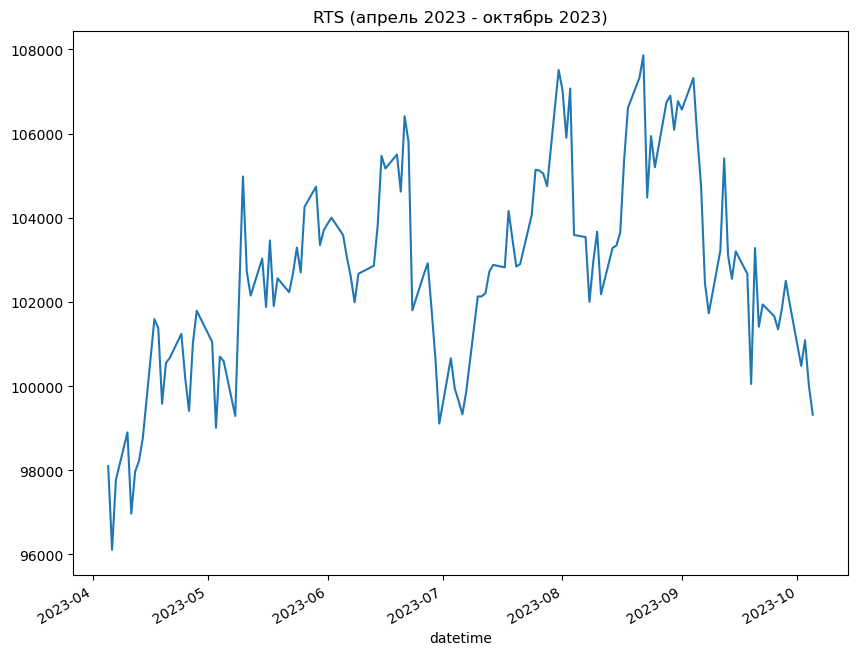

In [8]:
plt.figure(figsize=(10, 8))
plt.title('RTS (апрель 2023 - октябрь 2023)')
df['close'].plot();

В качестве признаков осавим цену закрытия и объем.

In [9]:
df = df[['close', 'vol']]
df

,close,vol
datetime,,
2023-04-05,98100.0,92118
2023-04-06,96110.0,114772
2023-04-07,97770.0,152611
2023-04-10,98900.0,104117
2023-04-11,96970.0,137115
...,...,...
2023-09-29,101970.0,100493
2023-10-02,100480.0,78336
2023-10-03,101090.0,75712


## Добавляем выходные

In [10]:
df.index.is_monotonic_increasing  # проверим порядок

True

Даты идут в хронологическом порядке, но отсутствуют данные за выходные дни т.к. торговля не производится.  
Добавим выходные.

In [11]:
idx = pd.date_range('2023-04-05', '2023-10-05')
df = df.reindex(idx)

In [12]:
df.head(15)

,close,vol
2023-04-05,98100.0,92118.0
2023-04-06,96110.0,114772.0
2023-04-07,97770.0,152611.0
2023-04-08,NaN,NaN
2023-04-09,NaN,NaN
2023-04-10,98900.0,104117.0
2023-04-11,96970.0,137115.0
2023-04-12,97970.0,104603.0
2023-04-13,98220.0,94369.0
2023-04-14,98770.0,93872.0


Цены на выходных заполним значением пятницы

In [13]:
df = df.ffill()

In [14]:
df.head(20)

,close,vol
2023-04-05,98100.0,92118.0
2023-04-06,96110.0,114772.0
2023-04-07,97770.0,152611.0
2023-04-08,97770.0,152611.0
2023-04-09,97770.0,152611.0
2023-04-10,98900.0,104117.0
2023-04-11,96970.0,137115.0
2023-04-12,97970.0,104603.0
2023-04-13,98220.0,94369.0
2023-04-14,98770.0,93872.0


**Вывод**  
На данном этапе мы:

1. Ознакомились с данными;
2. Заполнили пропуски в выходные дни.

# 2 Анализ

Построим графики тренда, сезонной составляющей и остатков.

In [15]:
decomposed = seasonal_decompose(df['close'])

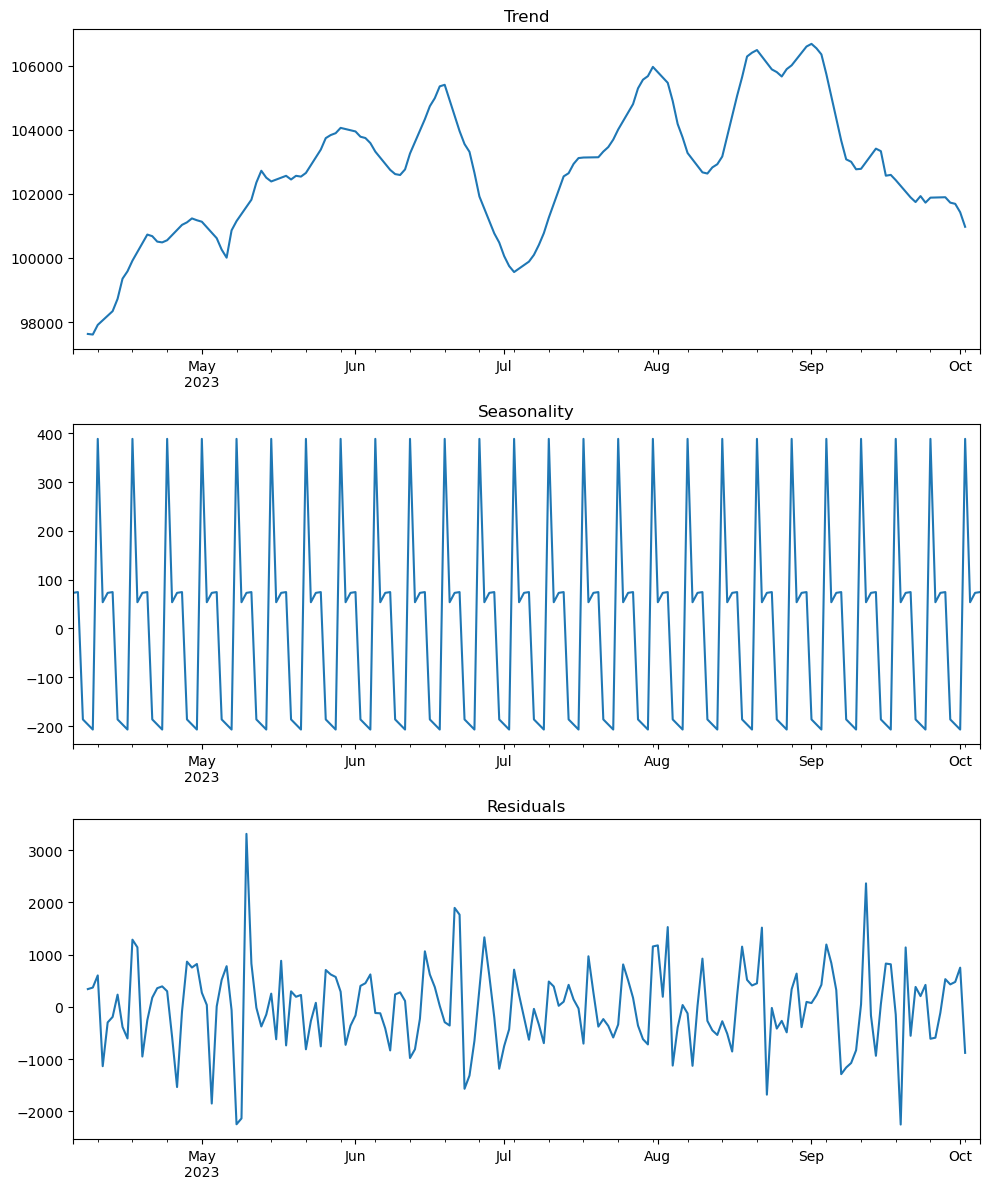

In [16]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На данном временном промежутке тренд отсутствует.

Рассмотрим сезонность подробнее.

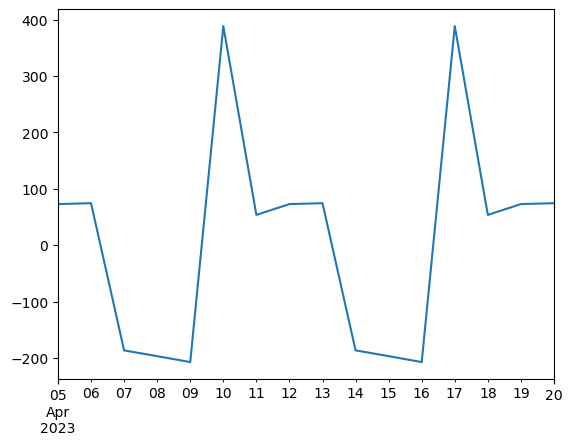

In [17]:
decomposed.seasonal['2023-04-05':'2023-04-20'].plot(ax=plt.gca());

На графике можно заметить недельную сезонность.

# Напишем функцию для создания новых признаков

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek  # признак день недели
#     df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['close'].shift(lag)  # параметр авторегрессии

    df['rolling_mean'] = df['close'].shift().rolling(rolling_mean_size).mean()  # тренд

In [19]:
make_features(df, 7, 7)  #  сезонность 7 дней

In [20]:
df.head()

,close,vol,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
2023-04-05,98100.0,92118.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,96110.0,114772.0,3,98100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-07,97770.0,152611.0,4,96110.0,98100.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-08,97770.0,152611.0,5,97770.0,96110.0,98100.0,NaN,NaN,NaN,NaN,NaN
2023-04-09,97770.0,152611.0,6,97770.0,97770.0,96110.0,98100.0,NaN,NaN,NaN,NaN


In [21]:
df[-1:]

,close,vol,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
2023-10-05,99320.0,69248.0,3,100010.0,101090.0,100480.0,101970.0,101970.0,101970.0,102500.0,101427.142857


In [22]:
df.tail(20)

,close,vol,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
2023-09-16,103200.0,104075.0,5,103200.0,102550.0,103110.0,105410.0,103220.0,101730.0,101730.0,102992.857143
2023-09-17,103200.0,104075.0,6,103200.0,103200.0,102550.0,103110.0,105410.0,103220.0,101730.0,103202.857143
2023-09-18,102670.0,64135.0,0,103200.0,103200.0,103200.0,102550.0,103110.0,105410.0,103220.0,103412.857143
2023-09-19,100050.0,122204.0,1,102670.0,103200.0,103200.0,103200.0,102550.0,103110.0,105410.0,103334.285714
2023-09-20,103280.0,44841.0,2,100050.0,102670.0,103200.0,103200.0,103200.0,102550.0,103110.0,102568.571429
2023-09-21,101410.0,118362.0,3,103280.0,100050.0,102670.0,103200.0,103200.0,103200.0,102550.0,102592.857143
2023-09-22,101940.0,106670.0,4,101410.0,103280.0,100050.0,102670.0,103200.0,103200.0,103200.0,102430.000000
2023-09-23,101940.0,106670.0,5,101940.0,101410.0,103280.0,100050.0,102670.0,103200.0,103200.0,102250.000000
2023-09-24,101940.0,106670.0,6,101940.0,101940.0,101410.0,103280.0,100050.0,102670.0,103200.0,102070.000000
2023-09-25,101660.0,74770.0,0,101940.0,101940.0,101940.0,101410.0,103280.0,100050.0,102670.0,101890.000000


В тренировочной выборке оставим данные до 22 сентября.

In [23]:
X_train_5 = df.loc['2023-04-05':'2023-09-22'].dropna()
y_train_5 = X_train_5['close']
X_train_5 = X_train_5.drop('close', axis=1)
X_train_5

,vol,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
2023-04-12,104603.0,2,96970.0,98900.0,97770.0,97770.0,97770.0,96110.0,98100.0,97627.142857
2023-04-13,94369.0,3,97970.0,96970.0,98900.0,97770.0,97770.0,97770.0,96110.0,97608.571429
2023-04-14,93872.0,4,98220.0,97970.0,96970.0,98900.0,97770.0,97770.0,97770.0,97910.000000
2023-04-15,93872.0,5,98770.0,98220.0,97970.0,96970.0,98900.0,97770.0,97770.0,98052.857143
2023-04-16,93872.0,6,98770.0,98770.0,98220.0,97970.0,96970.0,98900.0,97770.0,98195.714286
...,...,...,...,...,...,...,...,...,...,...
2023-09-18,64135.0,0,103200.0,103200.0,103200.0,102550.0,103110.0,105410.0,103220.0,103412.857143
2023-09-19,122204.0,1,102670.0,103200.0,103200.0,103200.0,102550.0,103110.0,105410.0,103334.285714
2023-09-20,44841.0,2,100050.0,102670.0,103200.0,103200.0,103200.0,102550.0,103110.0,102568.571429
2023-09-21,118362.0,3,103280.0,100050.0,102670.0,103200.0,103200.0,103200.0,102550.0,102592.857143


In [24]:
predictions_5 = []
predictions_5

[]

### Обучим модель линейной регрессии

In [25]:
model_5 = LinearRegression()

In [26]:
model_5.fit(X_train_5, y_train_5)

LinearRegression()

Получим предсказание для 5 дней с 25 по 29 сентября. (Предсказание делаем на следующий день и знаем цену закрытия сегодняшнего дня)

In [27]:
for i in range(0, 5):
    X_test_5 = df[-12+i:-11+i].drop('close', axis=1)
    predictions_5.append(int(model_5.predict(X_test_5)))

In [28]:
predictions_5

[101588, 102681, 102513, 102049, 102324]

Занесем предсказания в таблицу и сравним с реальными значениями цены за этот промежуток.

In [29]:
df_predictions = pd.DataFrame({'close': predictions_5}, index=pd.date_range('2023-09-25', '2023-09-29'))
df_predictions

,close
2023-09-25,101588
2023-09-26,102681
2023-09-27,102513
2023-09-28,102049
2023-09-29,102324


In [30]:
df_true = df.iloc[-11:-6, 0:1]
df_true

,close
2023-09-25,101660.0
2023-09-26,101350.0
2023-09-27,101850.0
2023-09-28,102500.0
2023-09-29,101970.0


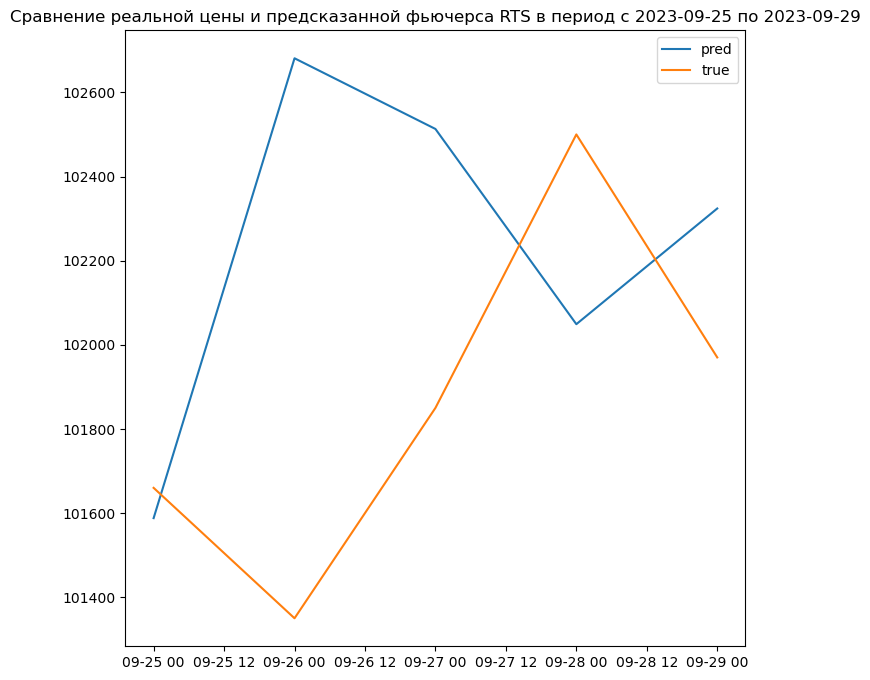

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(df_predictions, label='pred')
plt.plot(df_true, label='true')
plt.title('Сравнение реальной цены и предсказанной фьючерса RTS в период с 2023-09-25 по 2023-09-29')
plt.legend()
plt.show();

Используем TimeSeriesSplit кросс-валидатор и оценим качество модели на тренировочных данных.

In [32]:
tscv = TimeSeriesSplit()

In [33]:
model_5 = LinearRegression()
mse = (-1) * cross_val_score(model_5, X_train_5, y_train_5, cv=tscv, scoring='neg_mean_squared_error').mean()

print("RMSE обучающей выборки:", mse ** 0.5)

RMSE обучающей выборки: 1331.5154170956644


## Проверка на адекватность

Спрогнозируем новое значение предыдущим значением ряда.

In [34]:
pred_previous = y_train_5.shift(1).fillna(97970)
print("RMSE константной модели:", mean_squared_error(y_train_5, pred_previous) ** 0.5)

RMSE константной модели: 1159.8656881872773


**Вывод**  
Наша модель дает худшую точность чем предсказания константной модели. В таком виде использовать ее нельзя.

### Как можно улучшить предсказания

1. Сделать ряд более стационарным (дифференцирования ряда);
2. Использовать модель ARIMA;
3. Взять меньший период для обучения;
4. Использовать другие фичи.